# 1. Overview

## Description

**Why This Matters**

Accurate sales forecasts are crucial for planning process, supply chain processes, delivery logistics and inventory management. By optimizing forecasts, we can minimize waste and streamline operations, making our e-grocery services more sustainable and efficient.

**Your Impact**

Your participation in this challenge will directly contribute to Rohlik mission of sustainable and efficient e-grocery delivery. Your insights will help us enhance customer service and achieve a greener future.

We are relaunching the Challenge with prizes.

Rohlik Group, a leading European e-grocery innovator, is revolutionising the food retail industry. We operate across 11 warehouses in Czech Republic, Germany, Austria, Hungary, and Romania.

We are now transitioning from the Rohlik Orders Forecasting Challenge to the Rohlik Sales Forecasting Challenge, as we continue with our set of challenges. This challenge focuses on predicting the sales of each selected warehouse inventory for next 14 days using historical sales data.

## Evaluation

Submissions are evaluated on Weighted Mean Absolute Error (WMAE) between the predicted sales and the actual sales. Weights for the test evaluation can be found in the Data section.

## Submission File

For each ID in the test set, you must predict a probability for the TARGET variable. The file should contain a header and have the following format:

id,sales_hat

840_2024-06-10,12.01

2317_2024-06-15,13.32

738_2024-06-10,14.12

3894_2024-06-11,3.03

3393_2024-06-08,53.03


## Prizes
Leaderboard prizes

1st place - $4,000

2nd place - $4,000

3rd place - $2,000

## Citation

MichalKecera. Rohlik Sales Forecasting Challenge. https://kaggle.com/competitions/rohlik-sales-forecasting-challenge-v2, 2024. Kaggle.

## Data

## Dataset Description
You are provided with historical sales data for selected Rohlik inventory and date. IDs, sales, total orders and price columns are altered to keep the real values confidential. Some features are not available in test as they are not known at the moment of making the prediction. The task is to forecast the sales column for a given id, constructed from unique_id and date (e. g. id 1226_2024-06-03 from unique_id 1226 and date 2024-06-03), for the test set.



## Files
- **sales_train.csv** - training set containing the historical sales data for given date and inventory with selected features described below
- **sales_test.csv** - full testing set
- **inventory.csv** - additional information about inventory like its product (same products across all warehouses share same product unique id and name, but have different unique id)
- **solution.csv** - full submission file in the correct format
- **calendar.csv** - calendar containing data about holidays or warehouse specific events, some columns are already in the train data but there are additional rows in this file for dates where some warehouses could be closed due to public holiday or Sunday (and therefore they are not in the train set)



## Columns
**sales_train.csv** and **sales_test.csv**

- `unique_id` - unique id for inventory
- `date` - date
- `warehouse` - warehouse name
- `total_orders` - historical orders for selected Rohlik warehouse known also for test set as a part of this challenge
- `sales` - Target value, sales volume (either in pcs or kg) adjusted by availability. The sales with lower availability than 1 are already adjusted to full potential sales by Rohlik internal logic. There might be missing dates both in train and test for a given inventory due to various reasons. This column is missing in test.csv as it is target variable.
- `sell_price_main` - sell price
- `availability` - proportion of the day that the inventory was available to customers. The inventory doesn't need to be available at all times. A value of 1 means it was available for the entire day. This column is missing in test.csv as it is not known at the moment of making the prediction.
- `type_0_discount`, type_1_discount, … - Rohlik is running different types of promo sale actions, these show the percentage of the original price during promo ((original price - current_price) / original_price). Multiple discounts with different type can be run at the same time, but always the highest possible discount among these types is used for sales. Negative discount value should be interpreted as no discount.

**inventory.csv**

- `unique_id` - inventory id for a single keeping unit
- `product_unique_id` - product id, inventory in each warehouse has the same product unique id (same products across all warehouses has the same product id, but different unique id)
- `name` - inventory id for a single keeping unit
L1_category_name, L2_category_name, … - name of the internal category, the higher the number, the more granular information is present
- `warehouse` - warehouse name

**calendar.csv**

- `warehouse` - warehouse name
- `date` - date
- `holiday_name` - name of public holiday if any
- `holiday` - 0/1 indicating the presence of holidays
- `shops_closed` - public holiday with most of the shops or large part of shops closed
- `winter_school_holidays` - winter school holidays
- `school_holidays` - school holidays

**test_weights.csv**

- `unique_id` - inventory id for a single keeping unit
- `weight` - weight used for final metric computation

# Import & Merging

## Basic

Mount Drive if in a Colab environment

In [63]:
# from google.colab import drive
# drive.mount('/content/drive')

Import packages and tables

In [64]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [65]:
path = r''

sales_train = pd.read_csv(f'{path}sales_train.csv')
sales_test = pd.read_csv(f'{path}sales_test.csv')
weights = pd.read_csv(f'{path}test_weights.csv')
solution = pd.read_csv(f'{path}solution.csv')
inventory = pd.read_csv(f'{path}inventory.csv')
calendar = pd.read_csv(f'{path}calendar.csv')
prague_weather = pd.read_csv(f'{path}weather/prague_weather.csv', index_col=False)
brno_weather = pd.read_csv(f'{path}weather/brno_weather.csv', index_col=False)
frankfurt_weather = pd.read_csv(f'{path}weather/frankfurt_weather.csv', index_col=False)
munich_weather = pd.read_csv(f'{path}weather/munich_weather.csv', index_col=False)
budapest_weather = pd.read_csv(f'{path}weather/budapest_weather.csv', index_col=False)

In [66]:
# drop availability column
sales_train.drop(columns=['availability'], axis=1, inplace=True)

# drop 52 rows with NA values
sales_train.dropna(inplace=True)

# concat sales dataframes
df = pd.concat([sales_train,
                sales_test],
                ignore_index=True)

In [67]:
# convert to datetime
df['date'] = pd.to_datetime(df['date'])

Treating `discount` columns as instructed in Overview

In [68]:
# Create discount column by selecting max discount value across discount columns
discount_cols = [col for col in df.columns if col.startswith('type_') and col.endswith('_discount')]
df['discount'] = df[discount_cols].max(axis=1)

# drop discount columns
df.drop(columns = ['type_0_discount', 'type_1_discount', 'type_2_discount',
                            'type_3_discount', 'type_4_discount', 'type_5_discount',
                            'type_6_discount'], inplace = True)


## Basic date features


In [69]:
# Extract date features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.day_of_week
df['day_of_year'] = df['date'].dt.day_of_year

## Inventory

In [70]:
# merge inventory table
df = df.merge(inventory, on=['unique_id', 'warehouse'], how='left')

## Calendar

In [71]:
calendar.head()

,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
0,2022-03-16,NaN,0,0,0,0,Frankfurt_1
1,2020-03-22,NaN,0,0,0,0,Frankfurt_1
2,2018-02-07,NaN,0,0,0,0,Frankfurt_1
3,2018-08-10,NaN,0,0,0,0,Frankfurt_1
4,2017-10-26,NaN,0,0,0,0,Prague_2


In [72]:
# convert to datetime
calendar['date'] = pd.to_datetime(calendar['date'])

# Initialize new column
calendar['days_till_next_holiday'] = np.nan

# Process each warehouse separately
for warehouse, group in calendar.groupby('warehouse'):
    # Get unique, sorted holiday dates for this warehouse
    holiday_dates = np.sort(group.loc[group['holiday'] == 1, 'date'].unique())

    if len(holiday_dates) > 0:  # Only proceed if holidays exist
        # Use searchsorted to find index of the next holiday
        idx = np.searchsorted(holiday_dates, group['date'].values, side='right')

        # Fix index errors by ensuring we don’t go out of bounds
        valid_idx = idx < len(holiday_dates)

        # Create an array filled with NaT by default
        next_holiday_dates = np.full_like(group['date'].values, np.datetime64('NaT'), dtype='datetime64[D]')

        # Assign valid holiday dates only where index is within bounds
        next_holiday_dates[valid_idx] = holiday_dates[idx[valid_idx]]

        # Compute days until the next holiday
        days_till_holiday = (next_holiday_dates - group['date'].values).astype('timedelta64[D]').astype(float)

        # Assign results back to the DataFrame
        calendar.loc[group.index, 'days_till_next_holiday'] = days_till_holiday


In [115]:
calendar = calendar.sort_values(by=['warehouse','date'],ascending=[True,True])
# Initialize the new column 'day_before_shops_close'
calendar['day_before_shops_close'] = np.nan

# Process each warehouse separately
for warehouse, group in calendar.groupby('warehouse'):
    # Ensure the group is sorted by date
    group = group.sort_values('date')

    # Get the 'shops_closed' values and corresponding dates for this warehouse
    shops_closed = group['shops_closed'].values
    dates = group['date'].values

    # Shift the 'shops_closed' to get the next day's value for comparison
    next_day_shops_closed = group['shops_closed'].shift(-1)  # Using shift instead of np.roll

    # Compute the 'day_before_shops_close' column where:
    # If today is closed (shops_closed == 1) and next day is also closed, assign 1; otherwise, 0.
    calendar.loc[group.index, 'day_before_shops_close'] = (next_day_shops_closed == 1).astype(int)


Mean Sales Per holiday

In [126]:
# merge calendar
df = df.merge(calendar, on=['date', 'warehouse'], how='left')

In [127]:
df['holiday_name'].fillna('Not a holiday', inplace=True)

In [128]:
# Calculate mean sales by 'warehouse' and 'shops_closed' 
df['mean_sales_shops_closed'] = df.groupby(['warehouse', 'shops_closed'])['sales'].transform('mean')


## Weather

In [ ]:
for i, j in enumerate([prague_weather,
                        brno_weather,
                        frankfurt_weather,
                        munich_weather,
                        budapest_weather]):
    j = j.rename(columns={'datetime': 'date'})
    j['date'] = pd.to_datetime(j['date'])

    # Assign back to the corresponding variable
    if i == 0:
        prague_weather = j
    elif i == 1:
        brno_weather = j
    elif i == 2:
        frankfurt_weather = j
    elif i == 3:
        munich_weather = j
    elif i == 4:
        budapest_weather = j

In [ ]:
# Warehouse to City Mapping
warehouse_city_map = {
    'Budapest_1': 'Budapest',
    'Prague_2': 'Prague',
    'Brno_1': 'Brno',
    'Prague_1': 'Prague',
    'Prague_3': 'Prague',
    'Munich_1': 'Munich',
    'Frankfurt_1': 'Frankfurt'
}

# Weather DataFrames Dictionary (assuming all have the same structure)
weather_dfs = {
    'Prague': prague_weather,
    'Brno': brno_weather,
    'Frankfurt': frankfurt_weather,
    'Munich': munich_weather,
    'Budapest': budapest_weather
    # Add other weather DataFrames as needed
}

# Specify the columns to keep from each weather DataFrame.
# Make sure to include 'date' because it's needed for the merge.
selected_cols = ['date', 'name', 'temp', 'feelslike', 'sunrise', 'sunset']

# Merge all weather DataFrames into one, while adding a 'city' column.
merged_weather = pd.concat([
    weather_dfs[city][selected_cols].assign(city=city)
    for city in weather_dfs
], ignore_index=True)

# Map warehouse to city and drop rows with unknown warehouses
df['city'] = df['warehouse'].map(warehouse_city_map)

# Now merge the sales data with the merged weather data on both 'date' and 'city'.
df = df.merge(merged_weather, on=['date', 'city'], how='left')

KeyboardInterrupt: 

## [Target encoding categorical variables](https://mlbook.explained.ai/catvars.html#target-encoding)


Overall Mean


In [ ]:
# Filter data before the given date
filtered_df = df[df['date'] < sales_train['date'].max()]

# Group by 'unique_id' and calculate the mean sales
mean_sales= filtered_df.groupby('unique_id')['sales'].mean().reset_index()

# Rename the resulting column
mean_sales.rename(columns={'sales': 'mean_sales'}, inplace=True)

# merging
df = df.merge(mean_sales, on='unique_id', how='left')


KeyboardInterrupt: 


Sell Price Main mean


In [ ]:
# Filter data before the given date
filtered_df = df[df['date'] < sales_train['date'].max()]

# Group by 'unique_id' and calculate the mean sales
mean_price= filtered_df.groupby('unique_id')['sell_price_main'].mean().reset_index()

# Rename the resulting column
mean_price.rename(columns={'sell_price_main': 'mean_price'}, inplace=True)

# merging
df = df.merge(mean_price, on='unique_id', how='left')


Name mean


In [ ]:
# Filter data before the given date
filtered_df = df[df['date'] < sales_train['date'].max()]

# Group by 'unique_id' and calculate the mean sales
mean_sales_name= filtered_df.groupby('name')['sales'].mean().reset_index()

# Rename the resulting column
mean_sales_name.rename(columns={'sales': 'mean_sales_name'}, inplace=True)

# merging
df = df.merge(mean_sales_name, on='name', how='left')


KeyError: 'name'


L3 Category mean


In [ ]:
# Filter data before the given date
filtered_df = df[df['date'] < sales_train['date'].max()]

# Group by 'L3_category_name_en' and calculate the mean sales
mean_sales_L3= filtered_df.groupby('L3_category_name_en')['sales'].mean().reset_index()

# Rename the resulting column
mean_sales_L3.rename(columns={'sales': 'mean_sales_L3'}, inplace=True)

# merging
df = df.merge(mean_sales_L3, on='L3_category_name_en', how='left')


Mean Sales per Holiday and Warehouse


In [ ]:
# # Filter data before the given date
# filtered_df = df[df['date'] < sales_train['date'].max()]

# # Group by 'L3_category_name_en' and calculate the mean sales
# mean_sales_holiday= filtered_df.groupby(['holiday_name', 'warehouse'])['sales'].mean().reset_index()

# # Rename the resulting column
# mean_sales_holiday.rename(columns={'sales': 'mean_sales_holiday'}, inplace=True)

# # merging
# df = df.merge(mean_sales_holiday, on=['holiday_name', 'warehouse'], how='left')
# df.tail()
# # df.drop(columns=inventory.columns[1:-1], inplace=True) # drop inventory columns, but unique_id and warehouse
# df.isna().sum()


In [ ]:
# # Ensure the 'date' column is in datetime format
# df['date'] = pd.to_datetime(df['date'])

# # Filter data before the given date
# filtered_df_1d = df

# # Set the date as the index for easier rolling operations
# filtered_df_1d = filtered_df_1d.sort_values('date').set_index('date')

# # Group by 'unique_id' and apply a rolling window of 1 day to calculate the mean sales
# mean_price_1d = (
#     filtered_df_1d.groupby('unique_id')['sell_price_main']
#     .rolling('1D')  # 1-day rolling window
#     .mean()
#     .reset_index()
# )

# # Rename the resulting column
# mean_price_1d.rename(columns={'sell_price_main': 'mean_price_1d'}, inplace=True)

# # Merging back with the original dataframe
# df = df.merge(mean_price_1d, on=['unique_id', 'date'], how='left')

## Frequency Encoding

In [ ]:
# Step 1: Self-merge to create pairs of rows with the same unique_id
merged_df = df.merge(
    df, 
    on='unique_id', 
    suffixes=('_left', '_right')
)

# Step 2: Filter for rows where the date difference is within 7 days
filtered_df = merged_df[
    (merged_df['date_right'] >= merged_df['date_left']) &
    (merged_df['date_right'] < merged_df['date_left'] + pd.Timedelta(days=7))
]

# Step 3: Count occurrences of unique_id within the 7-day window for each row
# Group by the original row's identifier (e.g., index) or date
unique_id_counts = (
    filtered_df.groupby('date_left')['unique_id']
    .transform('count')
)

# Step 4: Assign the counts back to the original dataframe
# Since 'date_left' comes from the original df, we can align it back
df = df.merge(
    filtered_df.groupby(['date_left', 'unique_id']).size().reset_index(name='unique_id_count'),
    left_on=['date', 'unique_id'],
    right_on=['date_left', 'unique_id'],
    how='left'
)

# Fill NaN with 0 for dates with no matches
df['unique_id_count_7d'] = df['unique_id_count'].fillna(0).astype(int)

# Drop extra columns if needed
df = df.drop(columns=['date_left'])

MemoryError: Unable to allocate 32.8 GiB for an array with shape (4402274242,) and data type int64

In [ ]:
df.tail()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,discount,year,month,day,day_of_week,day_of_year,rolling_mean_7d,rolling_mean_14d,rolling_mean_30d,lag_1d,mean_sales,mean_price,unique_id_count
4054383,4429,2024-06-16,Prague_3,5390.0,NaN,107.89,0.0,2024,6,16,6,168,43.787143,78.962857,85.599000,23.10,43.454002,106.621827,1014
4054384,362,2024-06-16,Prague_3,5390.0,NaN,61.90,0.0,2024,6,16,6,168,48.998571,80.330000,84.357333,107.89,118.927391,61.900000,56
4054385,4532,2024-06-16,Prague_3,5390.0,NaN,110.78,0.0,2024,6,16,6,168,53.472857,82.502857,81.739000,61.90,37.486064,92.752413,1385
4054386,4365,2024-06-16,Prague_3,5390.0,NaN,80.92,0.0,2024,6,16,6,168,62.721429,72.576429,83.669667,110.78,10.496471,74.066362,1373
4054387,2125,2024-06-16,Prague_3,5390.0,NaN,19.44,0.0,2024,6,16,6,168,60.545714,71.492857,82.365000,80.92,16.149672,18.863162,1416


In [ ]:
df.isna().sum()

unique_id               0
date                    0
warehouse               0
total_orders            0
sales               47021
sell_price_main         0
discount                0
year                    0
month                   0
day                     0
day_of_week             0
day_of_year             0
rolling_mean_7d         0
rolling_mean_14d        0
rolling_mean_30d        0
lag_1d                  0
mean_sales              0
mean_price              0
unique_id_count         0
dtype: int64

# Preprocessing

In [ ]:
# splitting sales_df
train = df[df['date'] < sales_test['date'].min()]
test = df[df['date'] >= sales_test['date'].min()]

In [ ]:
#used to stratify the dataset
train['sales_bins'] = pd.qcut(train['sales'], q=4, labels=[1, 2, 3, 4])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

random_state = 1910

# Initialize the LabelEncoder
le = LabelEncoder()

#tranform categorical variables in both df
for i in train.select_dtypes('object').columns:
        train[i] = le.fit_transform(train[i])

#tranform categorical variables in both df
for i in test.select_dtypes('object').columns:
        test[i] = le.fit_transform(test[i])

X = train.drop(columns=['date', 'sales', 'sales_bins'], axis=1)
y = train['sales']

test = test[X.columns]

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.20,
                                                  stratify=train['sales_bins'],
                                                  random_state=random_state)

# Light GB

In [ ]:
import lightgbm as lgb

# LightGBM parameters
lgb_params = {
    "objective": "regression",  # Predicting sales (continuous target)
    "metric": "rmse",  # Root Mean Squared Error (good for scale-dependent forecasting)
    "boosting_type": "gbdt",  # Gradient Boosting Decision Trees
    "learning_rate": 0.1420398253339109,  # Controls step size (0.05 is a good starting point)
    "num_leaves": 143,  # Controls tree complexity (higher = risk of overfitting)
    "max_depth": 14,  # No depth limit
    "subsample": 0.5809918835810081,  # Use 80% of data per tree (reduces overfitting)
    "colsample_bytree": 0.768425331779863,  # Use 80% of features per tree
    "n_estimators": 1000,  # Number of boosting rounds
    "early_stopping_rounds": 50,  # Stops training if validation score doesn't improve
    "verbose": -1,  # Suppress warnings
}

# Train the model
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

model = lgb.train(
    lgb_params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
)

In [ ]:
from sklearn.metrics import mean_absolute_error

# Predict on validation set
y_pred = model.predict(X_val)

# Evaluate performance
mae = mean_absolute_error(y_val, y_pred)
print(f"Validation MAE: {mae:.2f}")

Validation MAE: 21.42


In [ ]:
# weights
X_val_weighted = X_val.merge(weights, on=['unique_id'], how='left')

# Compute WMAE
X_val_weighted['abs_error'] = np.abs(y_val-y_pred)

wmae = (np.sum(X_val_weighted['abs_error'] * X_val_weighted['weight']) / X_val_weighted['weight'].sum())

print("The Weighted Mean Absolute Error is: ", wmae)

The Weighted Mean Absolute Error is:  5.872468889733546


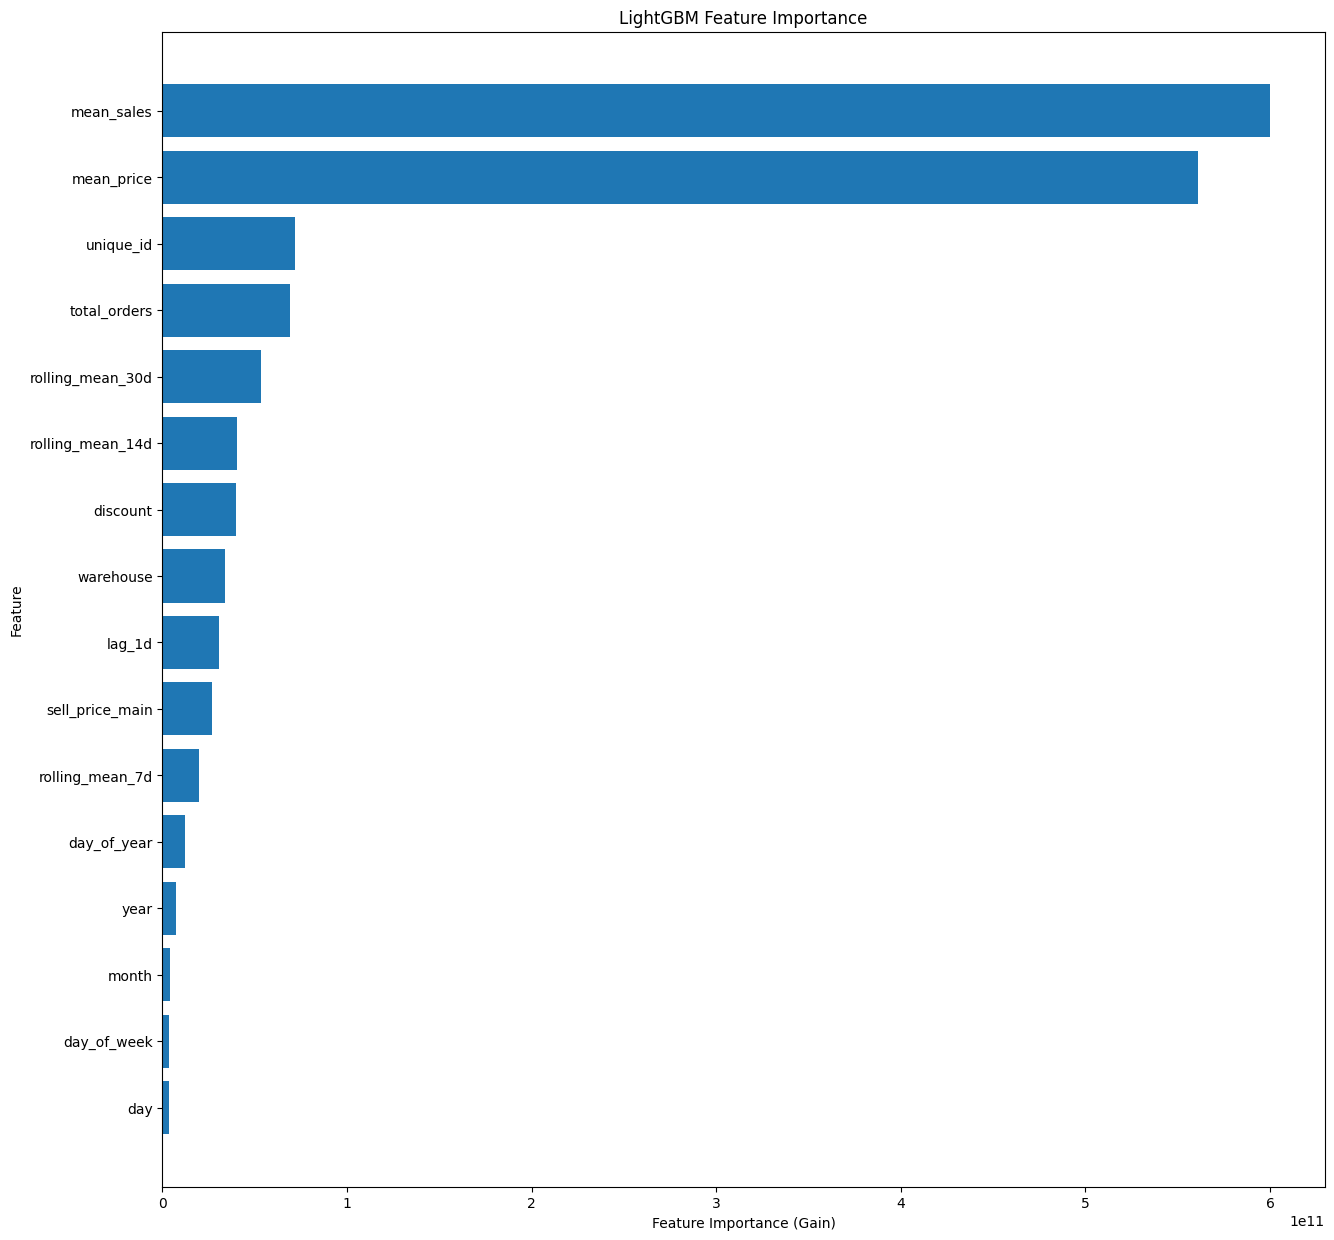

In [ ]:
# Get feature importance values
importance = model.feature_importance(importance_type="gain")  # 'gain' shows impact per split
feature_names = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(importance)[::-1]

# Plot
plt.figure(figsize=(15, 15))
plt.barh(range(len(sorted_idx)), importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance (Gain)")
plt.ylabel("Feature")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()  # Highest importance at top
plt.show()

In [ ]:
# checking individual importances
importances = pd.DataFrame(model.feature_importance(importance_type='gain'), X.columns)
importances.sort_values(by=0, ascending=False, inplace=True)

In [ ]:
predictions = model.predict(test)

solution['sales_hat'] = predictions

# Ensure the indices of 'solution' and 'test' match
solution = solution.reset_index(drop=True)
test = test.reset_index(drop=True)

solution.head()

,id,sales_hat
0,1226_2024-06-03,9.158919
1,1226_2024-06-11,16.339855
2,1226_2024-06-13,23.674770
3,1226_2024-06-15,47.973498
4,1226_2024-06-09,42.259398


In [ ]:
# solution.to_csv(f'solution_wmae_{wmae:.2f}.csv', index=False)

# Randon Forest Regressor

In [ ]:

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=random_state, oob_score=True)

rf.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import mean_absolute_error

predictions = rf.predict(X_val)
mae = mean_absolute_error(y_val, predictions)
print("Mean Absolute Error: ", mae)

Mean Absolute Error:  18.48317830409969


In [ ]:
# weights
X_val_weighted = X_val.merge(weights, on=['unique_id'], how='left')

# Compute WMAE
X_val_weighted['abs_error'] = np.abs(y_val-predictions)

wmae = (np.sum(X_val_weighted['abs_error'] * X_val_weighted['weight']) / X_val_weighted['weight'].sum())

print("The Weighted Mean Absolute Error is: ", wmae)

The Weighted Mean Absolute Error is:  5.106448195523912


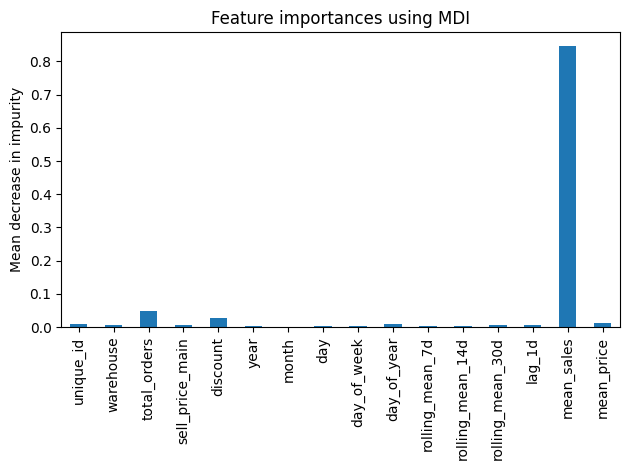

In [ ]:

#check feature importance
rf_importances = pd.DataFrame(rf.feature_importances_, X.columns)
fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax, legend=False)
ax.set_title("Feature importances using MDI")  # mean decrease in impurity
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [ ]:
# def test(X, y):
#     rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
#     rf.fit(X, y)
#     oob = rf.oob_score_
#     n = rfnnodes(rf)
#     h = np.median(rfmaxdepths(rf))
#     print(f"OOB R^2 {oob:.5f} using {n:,d} tree nodes with {h} median tree height")
#     return rf, oob

# X, y = df[['interest_level']+numfeatures], df['price']
# rf, oob = test(X, y)

In [ ]:
predictions = rf.predict(test)

solution['sales_hat'] = predictions

solution.head()

,id,sales_hat
0,1226_2024-06-03,24.4662
1,1226_2024-06-11,24.1017
2,1226_2024-06-13,23.2540
3,1226_2024-06-15,50.1693
4,1226_2024-06-09,48.5099


In [ ]:
# solution.to_csv(f'solution_wmae_{wmae:.2f}.csv', index=False)

# Results

`df` = `sales_train` + `sales_test`

| # | Model | MAE | WMAE | DFs in training | Observations
|:-:|:-:|:-:|:-:|:-:|:-:|
| #0| Randon Forest |19.19|4.39|`df`| Nothing added, just basic instructions. Stratified by `sales_bins`
| #1| Randon Forest |18.37|4.22|`df`| Basic Target Encoding. Stratified by `sales_bins`
| #2| LightGB |21.36|4.69|`df`| The same as #1
| #3| Randon Forest |18.48|5.11|`df`| `Rolling` and `Lag` features added to #1. *Deleted* after trial